<a href="https://colab.research.google.com/github/dheerajvarma24/Adversarial_attack_and_training_task/blob/main/Adversarial_attack_and_training_HiWi_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
# Get the MNIST data
train_mnist = datasets.MNIST("../data", download=True, train=True, transform=transforms.ToTensor())
test_mnist = datasets.MNIST("../data", download=True, train=False, transform=transforms.ToTensor())
train_loader = DataLoader(train_mnist, batch_size=100, shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=100, shuffle=False)

In [22]:
# Define neural network model to train MNIST dataset
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

Define the adversarial attack type, here it is Projected Gradient Descent (PGD).


Compute the noise (delta) with respect to input's average L_2 & L_infinity norms.


Ref - https://adversarial-ml-tutorial.org/adversarial_examples/

In [23]:
def pgd(model, X, y, epsilon=2.0, alpha=0.1, num_iter=20):
    #initialize with zeros
    delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        #L_inifinity norm
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        #L_2 norm
        delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X) # to clip the X+delta to [0,1]
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)

        delta.grad.zero_()
    
    return delta.detach()

def norms(Z):
    # to compute norm
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]

In [24]:
#standard training and evaluation procedure 
def standard_epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset)


In [25]:
# Adversarial training and evaluation procedure 
def adversarial_epoch(loader, model, pgd, opt=None, **kwargs):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = pgd(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset)

In [26]:
# Perform actual training and monitor training, test and adversarial loss.
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err = standard_epoch(train_loader, model_cnn, opt)
    test_err = standard_epoch(test_loader, model_cnn)
    adv_err = adversarial_epoch(test_loader, model_cnn, pgd)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    if t==0:
      print("train err \ttest err  \tadv err")
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

train err 	test err  	adv err
0.280517	0.029600	0.466500
0.026983	0.018100	0.444000
0.017517	0.016000	0.419600
0.013283	0.015200	0.479700
0.009333	0.013300	0.492900
0.004333	0.010700	0.468700
0.002900	0.010100	0.481900
0.002450	0.010600	0.469700
0.002083	0.010800	0.480800
0.001917	0.010300	0.489100


In the above result, the standard train and test error on MNIST dataset is decreasing. However, the adversarial error is very high and increasing.

In [27]:
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

In [28]:
# visualize the examples from MNIST dataset
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

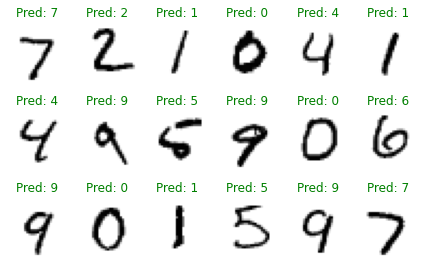

In [29]:
# Visualize test dataset samples accuracy classified by trained cnn model
yp = model_cnn(X)
plot_images(X, y, yp, 3, 6)

Note: In the above visualization the background of each image is completely white without any noise.

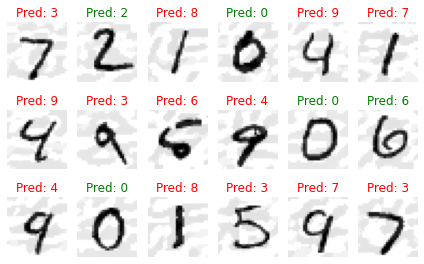

In [30]:
# Visualize test dataset samples accuracy that are perturbed by PGD attack and classified by trained cnn model
delta = pgd(model_cnn, X, y)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Note: In the above visualization the background of each image has some noise introduced by PGD attack. Therefore it has several misclassifications by the standard CNN model.

In [31]:
# Define another neural network model to perform adversarial train MNIST dataset
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [32]:
# Perform adversarial training and monitor training, test and adversarial loss.
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
for t in range(10):
    train_err = adversarial_epoch(train_loader, model_cnn_robust, pgd, opt)
    test_err = standard_epoch(test_loader, model_cnn_robust)
    adv_err = adversarial_epoch(test_loader, model_cnn_robust, pgd)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    if t==0:
      print("train err \ttest err  \tadv err")
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

train err 	test err  	adv err
0.397350	0.027400	0.079700
0.071817	0.014900	0.051700
0.049550	0.012500	0.043300
0.040517	0.011300	0.040300
0.033500	0.010700	0.035900
0.022500	0.009300	0.031600
0.021067	0.009000	0.031600
0.020600	0.008700	0.031300
0.019550	0.009600	0.031500
0.018950	0.008700	0.031300


In the above result, the standard train, test error as well adversarial error on MNIST dataset are decreasing. Thus, it indicates that the model is robust against the PGD adversarial attacks.

In [33]:
model_cnn_robust.load_state_dict(torch.load("model_cnn_robust.pt"))

<All keys matched successfully>

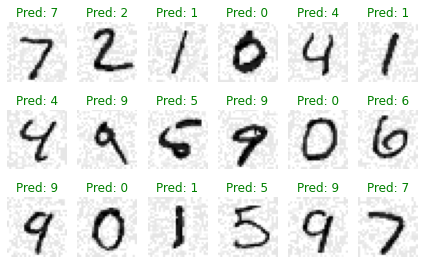

In [34]:
# Visualize test dataset samples accuracy that are perturbed by PGD attack and classified by trained cnn model
delta = pgd(model_cnn_robust, X, y)
yp = model_cnn_robust(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Note: In the above visualization, even though the background of each image has some noise introduced by PGD attack, the images are still classified correctly by the robust_cnn_model as it has been trained on this adversarial attacks.